<a href="https://colab.research.google.com/github/Raphael181/Raphael181/blob/main/Predicting_the_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import necessary modules
import os
import datetime

import IPython
import IPython.display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf



In [2]:
#Setup
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

For this project, we will be using the weather time series dataset recorded by the Max Planck Institute for Biogeochemistry
There are 14 different features. And the features were collected every 10 minutes, since 2003. For the seake of efficiency, we will use the data collected between 2009 and 2016

In [3]:
#Getting the dataset
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [4]:
#for the project, we will be dealing with hourly predictions
dataset = pd.read_csv(csv_path)
dataset = dataset[5::6]

date_time = pd.to_datetime(dataset.pop('Date Time'), format = '%d.%m.%Y %H:%M:%S')

In [5]:
dataset.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [6]:
#Inspect and cleanup our dataset
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [7]:
#Replace the min values of the wv and max wv with zeros
wv = dataset['wv (m/s)']
bad_windv = wv == -9999.00
wv[bad_windv] = 0.0

max_wv = dataset['max. wv (m/s)']
bad_maxwind = max_wv == -9999.00
max_wv[bad_maxwind] = 0.0

#check to see if the min values have been replaced with zero's
dataset['wv (m/s)'].min()
dataset['max. wv (m/s)'].min()

0.0

In [8]:
#Time to perfome feature engineer
#Convert the wind direction and velocity columns into wind vectors
wv = dataset.pop('wv (m/s)')
max_wv = dataset.pop('max. wv (m/s)')

#convert to radians
wd_rad = dataset.pop('wd (deg)')*np.pi / 180

#Calculate the wind x and y components
dataset['Wx'] = wv*np.cos(wd_rad)
dataset['Wy'] = wv*np.sin(wd_rad)

#Calculate the max wind x and y components
dataset['max Wx'] = wv*np.cos(wd_rad)
dataset['max Wy'] = wv*np.sin(wd_rad)

In [9]:
#The datetime column should be converted into seconds from string format
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [10]:
#The time in seconds is not usable so we have to convert it into a usable signal
day = 24*60*60
year = (365.2425)*day

dataset['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dataset['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dataset['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
dataset['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of dat signal')

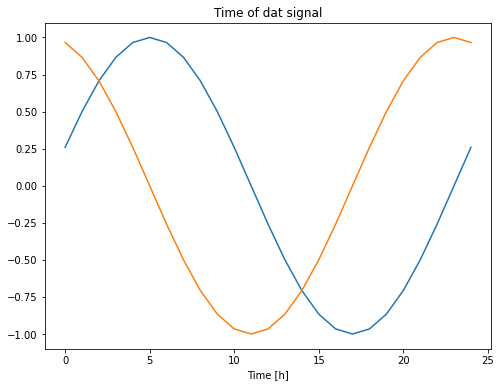

In [11]:
plt.plot(np.array(dataset['Day sin'])[:25])
plt.plot(np.array(dataset['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title("Time of dat signal")

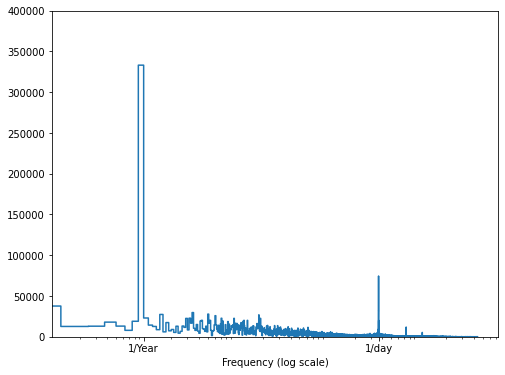

In [12]:
#Lets deternine which frequencies are important by using tf.signal.rfft
fft  = tf.signal.rfft(dataset['T (degC)']) 
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(dataset['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2541], labels = ['1/Year', '1/day'])
_ = plt.xlabel("Frequency (log scale)")

In [13]:
#Time to split the data
column_indices  ={name:  i for i, name in enumerate(dataset.columns)}

n = len(dataset)
train_df = dataset[0:int(n*0.7)]
val_df = dataset[int(n*0.7):int(n*0.9)]
test_df = dataset[int(n*0.9):]

num_features = dataset.shape[1]

In [14]:
#Normalize the data: subtarct the mean and divide by the standard deviation of feature
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [15]:
#Data windowing
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [16]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [17]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [18]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [19]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


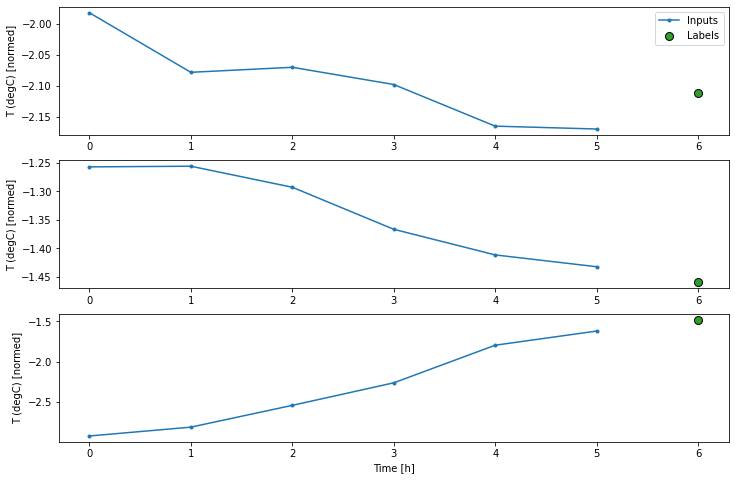

In [20]:
#Plot a simple visualizzation of the split window
w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

w2.plot()

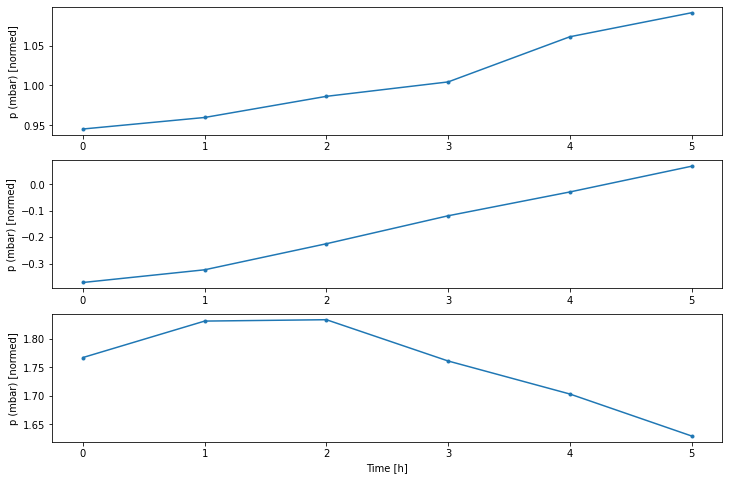

In [21]:
w2.plot(plot_col='p (mbar)')

In [22]:
#Create tf.data.Datasets
#the make dataset method will take a time series Dataframe and convert it into a tf.data.Dataset
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [23]:
#Add properties for accessing them as tf.data.Datasets using the 'make_dataset()' method
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [24]:
#Create a Linear transformation model between the input and the output
linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 1)
])

In [26]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [28]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear_model(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [29]:
#Create a function that contains the training procedure:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [30]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 1, 1)                20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [33]:
#Train the model and evaluate 
val_performance = {}
performance = {}
history = compile_and_fit(linear_model, single_step_window)
val_performance['Linear'] = linear_model.evaluate(single_step_window.val)
performance['Linear'] = linear_model.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0696 - val_loss: 0.0087 - val_mean_absolute_error: 0.0686
Epoch 2/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0086 - val_mean_absolute_error: 0.0684
Epoch 3/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0697 - val_loss: 0.0087 - val_mean_absolute_error: 0.0690
Epoch 4/20
439/439 [==============================] - 2s 3ms/step - loss: 0.0089 - mean_absolute_error: 0.0694


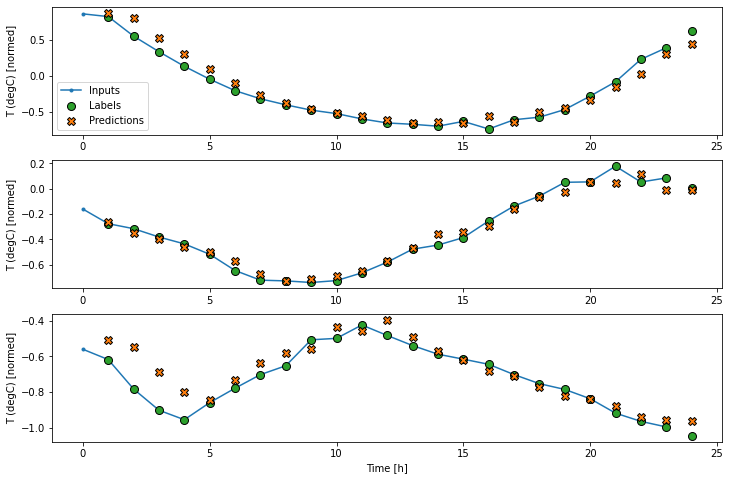

In [35]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

wide_window.plot(linear_model)

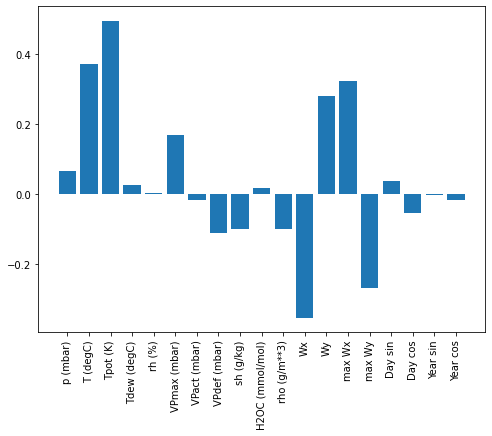

In [36]:
plt.bar(x = range(len(train_df.columns)),
        height=linear_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)